# Classification Test #1

In [1]:
import sdm as sdmlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import urllib, cStringIO
import random
from IPython.core.display import display, Image as IPythonImage
%matplotlib inline

In [2]:
width = 30
height = 30
noise_flip = True

In [3]:
def gen_img(letter='A'):
    img = Image.new('RGBA', (30, 30), (255, 255, 255))
    font = ImageFont.truetype('Arial.ttf', 30)
    draw = ImageDraw.Draw(img)
    draw.text((5, 0), letter, (0, 0, 0), font=font)
    return img

In [4]:
def gen_noise_add(img, p=0.15, flip=False):
    img2 = img.copy()
    draw = ImageDraw.Draw(img2)
    for py in xrange(height):
        for px in xrange(width):
            if random.random() < p:
                if flip:
                    pixel = img.getpixel((px, py))
                    value = sum([int(x/255+0.5) for x in pixel[:3]])//3
                    assert value == 0 or value == 1
                    value = (1 - value)*255
                    draw.point((px, py), fill=(value, value, value))
                else:
                    draw.point((px, py), fill=(0, 0, 0))
    return img2

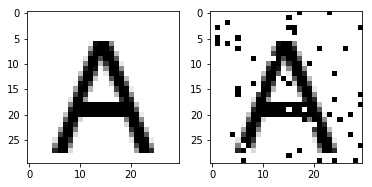

In [5]:
img = gen_img();
img2 = gen_noise_add(img, p=0.05, flip=noise_flip)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img2);

In [6]:
def to_bitstring(img):
    v = []
    bs = sdmlib.Bitstring.init_ones(1000)
    for py in xrange(height):
        for px in xrange(width):
            pixel = img.getpixel((px, py))
            value = sum([int(x/255+0.5) for x in pixel[:3]])//3
            assert value == 0 or value == 1
            idx = px+width*py
            assert idx >= 0 and idx < 1000, 'Ops {} {} {}'.format(x, y, idx)
            bs.set_bit(idx, value)
            v.append(value)
    v2 = [bs.get_bit(i) for i in xrange(height*width)]
    assert v == v2
    return bs

In [7]:
def to_img(bs):
    img = Image.new('RGBA', (30, 30), (255, 255, 255))
    draw = ImageDraw.Draw(img)
    for py in xrange(height):
        for px in xrange(width):
            idx = px+width*py
            assert idx >= 0 and idx < 1000, 'Ops {} {} {}'.format(x, y, idx)
            x = 255*bs.get_bit(idx)
            draw.point((px, py), fill=(x, x, x))
    return img

In [8]:
bits = 1000
sample = 1000000
scanner_type = sdmlib.SDM_SCANNER_OPENCL

In [9]:
address_space = sdmlib.AddressSpace.init_from_b64_file('sdm-letters.as')
counter = sdmlib.Counter.create_file('sdm-classification', bits, sample)
sdm = sdmlib.SDM(address_space, counter, 451, scanner_type)

In [53]:
for i in xrange(100):
    print i,
    b = sdmlib.Bitstring.init_random(1000)
    sdm.write(b, b)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99


In [10]:
def fill_memory(letter, label_bs, p=0.1, n=100):
    cols = 15
    rows = n//cols + 1
    plt.figure(figsize=(20,10))
    for i in xrange(n):
        img = gen_img(letter=letter);
        img2 = gen_noise_add(img, p=p, flip=noise_flip)
        #display(img2)
        plt.subplot(rows, cols, i+1)
        plt.imshow(img2)
        bs = to_bitstring(img2)
        bs.xor(label_bs)
        sdm.write(bs, bs)
    plt.show()

In [71]:
def read(letter, label_bs, n=6, p=0.2, radius=None):
    n = 7
    cols = 15
    rows = n//cols + 1
    plt.figure(figsize=(20,10))

    img = gen_img(letter=letter);
    img2 = gen_noise_add(img, p=p, flip=noise_flip)
    plt.subplot(rows, cols, 1)
    plt.imshow(img2)
    
    for i in xrange(n):
        bs2 = to_bitstring(img2)
        bs2.xor(label_bs)
        bs3 = sdm.read(bs2, radius=radius)
        if bs3 == bs2:
            break
        bs3.xor(label_bs)
        img3 = to_img(bs3)
        plt.subplot(rows, cols, i+2)
        plt.imshow(img3)
        img2 = img3

In [12]:
labels = list('ABCD8OQ')
label_to_bs = {}
for x in labels:
    label_to_bs[x] = sdmlib.Bitstring.init_random(1000)

Training for label A...


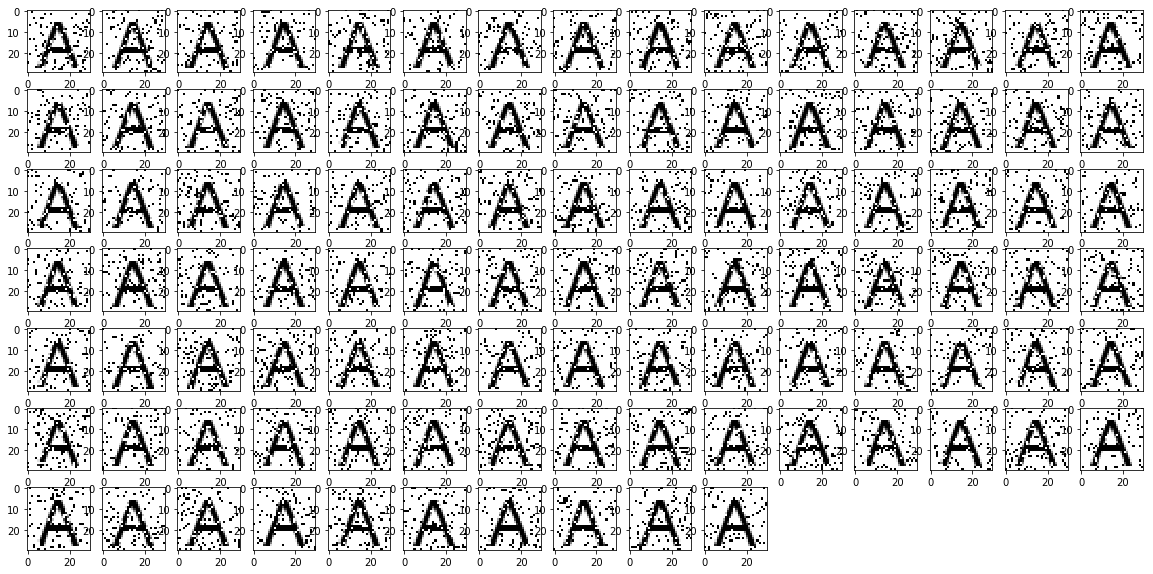

Training for label B...


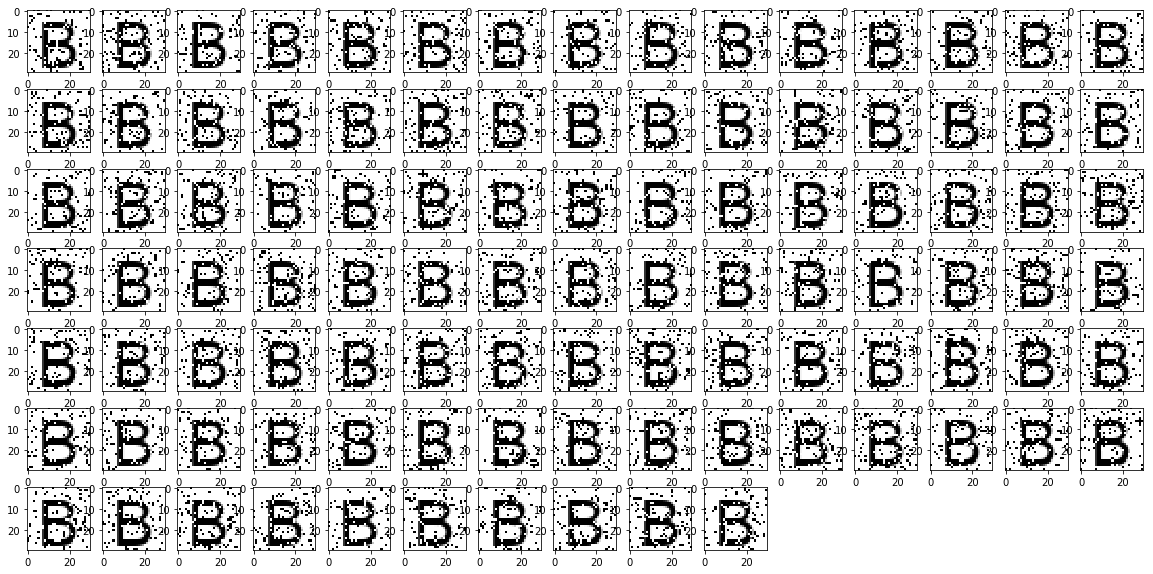

Training for label C...


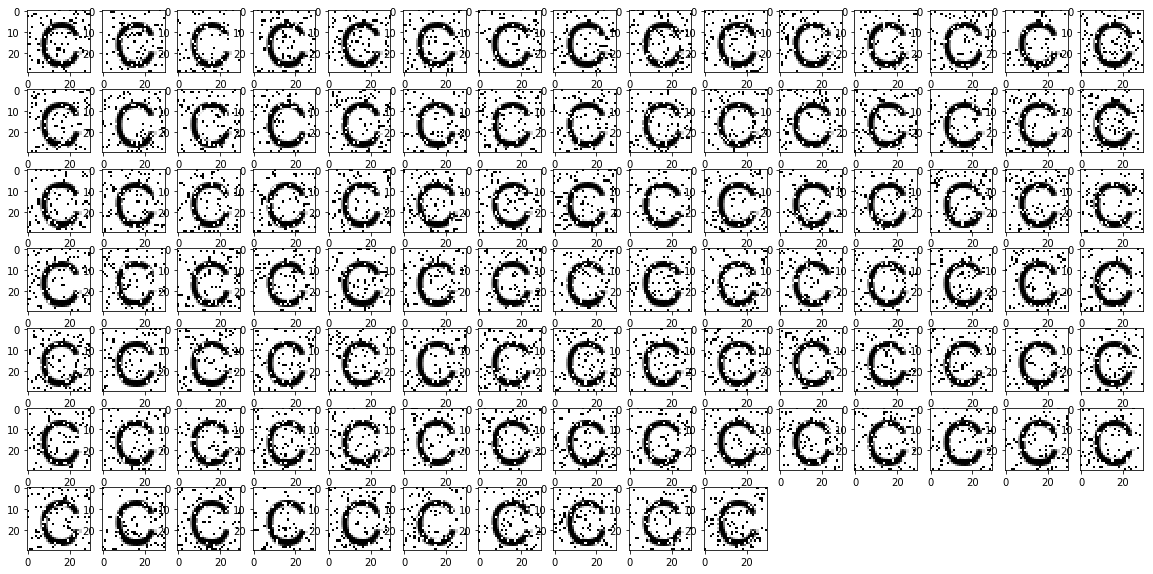

Training for label D...


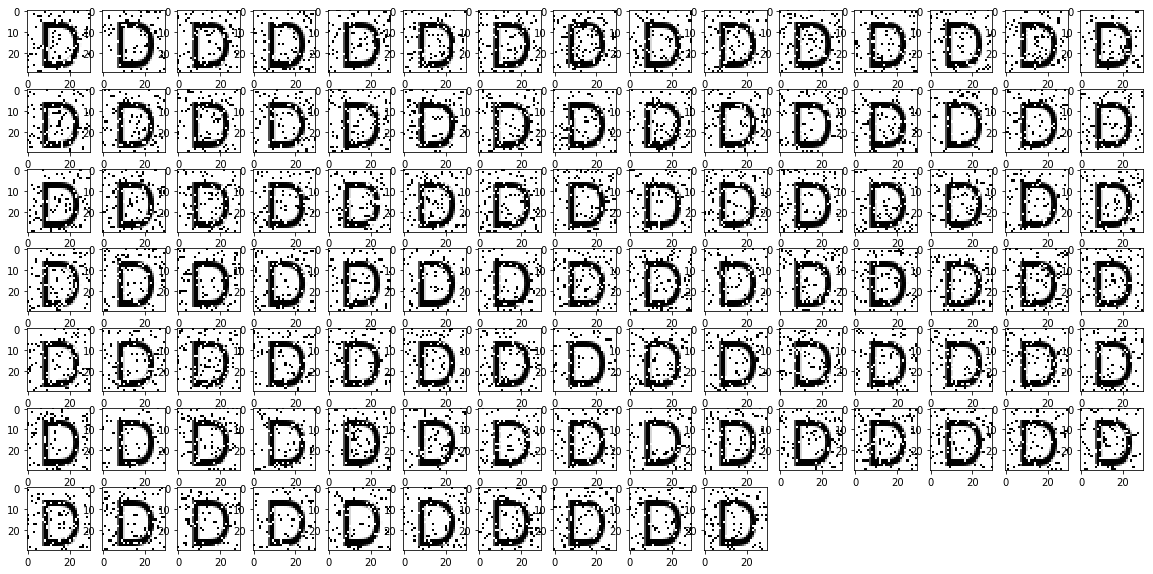

Training for label 8...


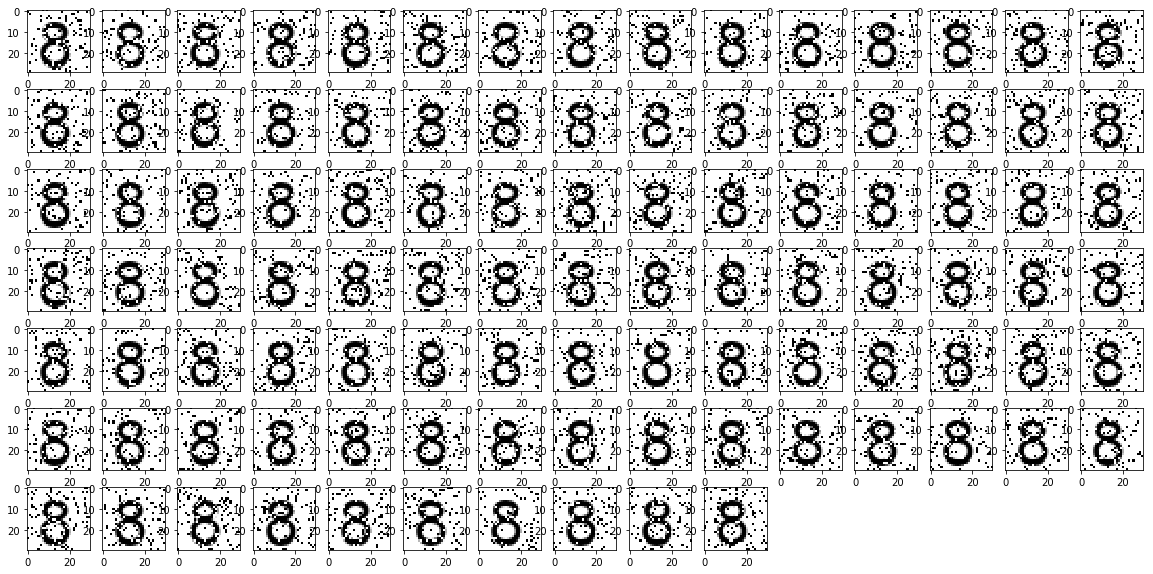

Training for label O...


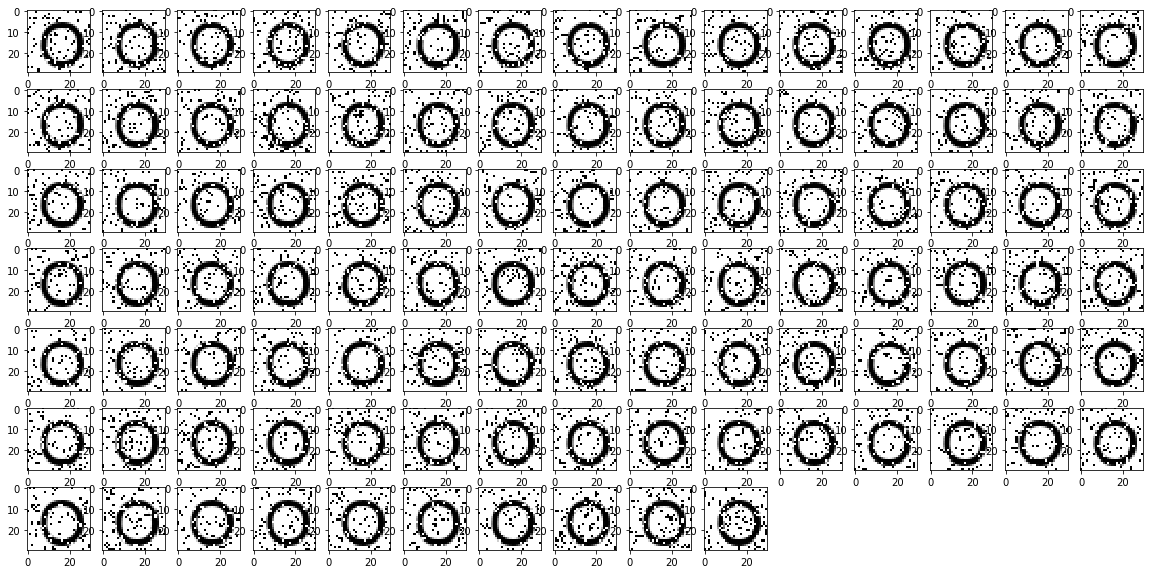

Training for label Q...


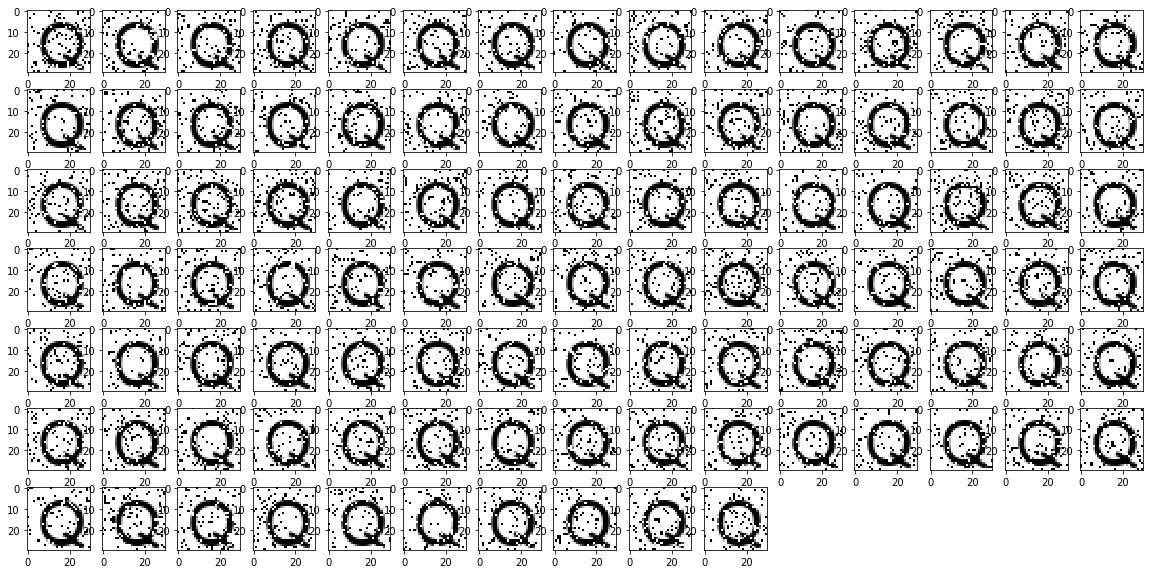

In [13]:
for x in labels:
    print 'Training for label {}...'.format(x)
    fill_memory(x, label_to_bs[x])

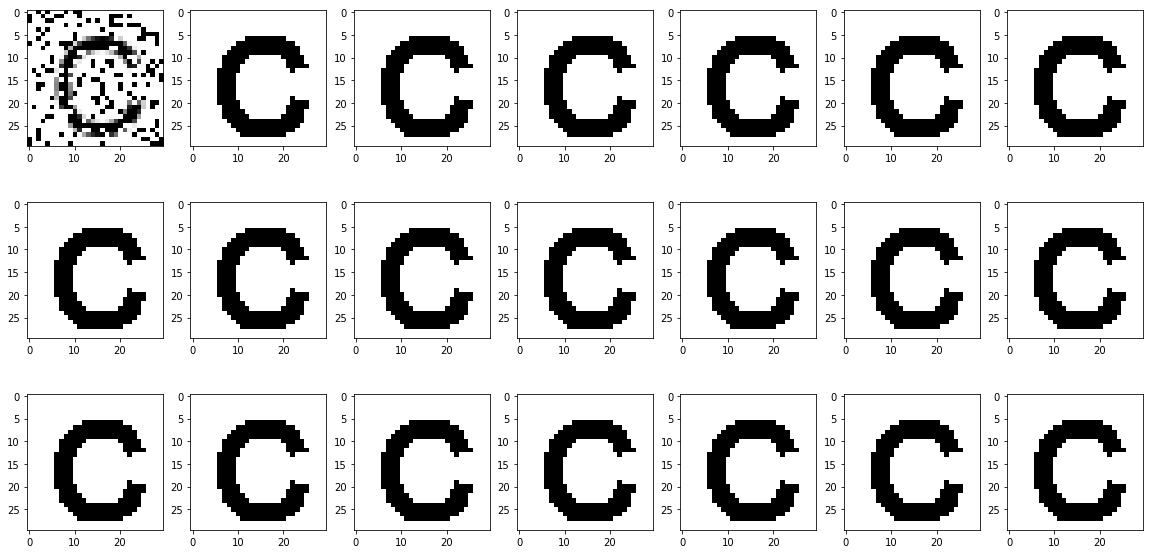

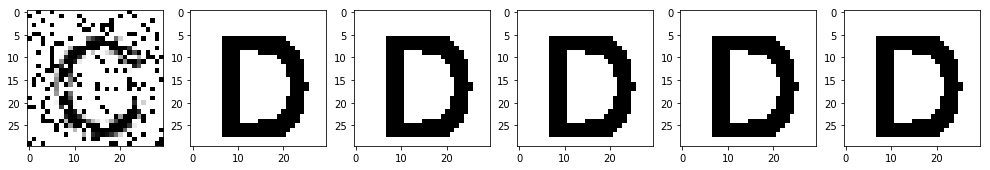

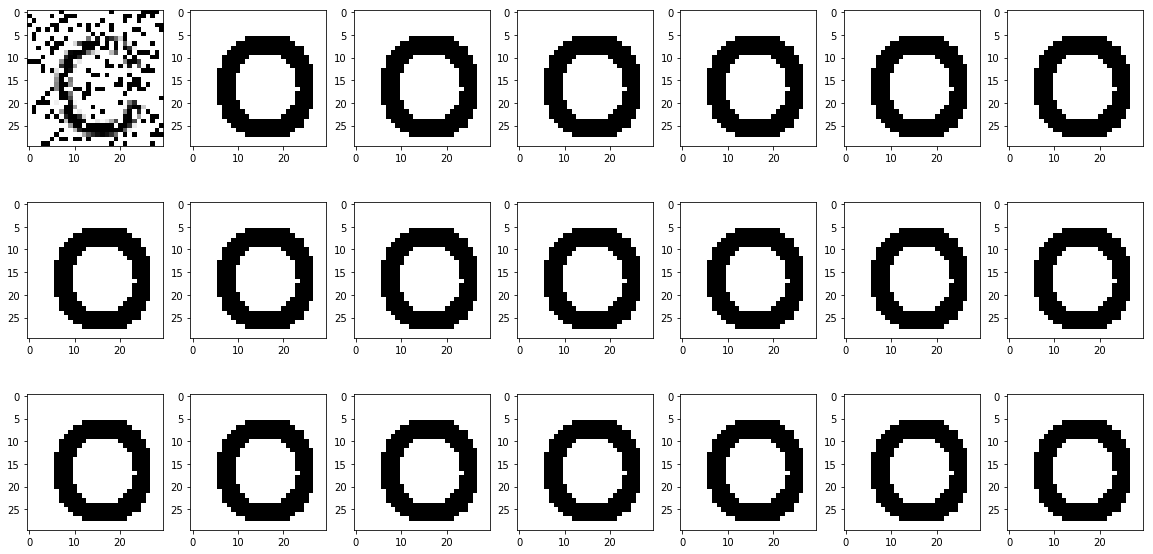

In [56]:
read('C', label_to_bs['C'])
read('C', label_to_bs['D'])
read('C', label_to_bs['O'])

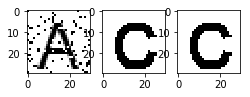

In [72]:
read('A', label_to_bs['C'], p=0.1)

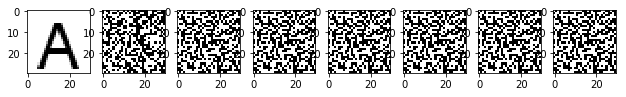

In [73]:
read('A', sdmlib.Bitstring.init_random(1000), p=0)

In [59]:
def intersection(a, b):
    bs1 = to_bitstring(gen_img(letter=a))
    bs2 = to_bitstring(gen_img(letter=b))
    hl1 = set(address_space.scan_thread(bs1, 451, 4))
    hl2 = set(address_space.scan_thread(bs2, 451, 4))
    return len(hl1 & hl2)
print intersection('B', '8')

200
